In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go 
import plotly.io as pio 
pio.renderers.default ='iframe'

import warnings 
warnings.filterwarnings('ignore')

In [2]:
from mnist_dataset import MNISTDataset 
#load dataset 
data = pd.read_csv('data/train.csv')
val_count =1000

#common transformation
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

#split the train to val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)


100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4314.12it/s]


In [3]:
#setup Dataloaders with pytorch dataloaders
trainloader = DataLoader(
    dataset,
    batch_size = 16,
    shuffle =True,
    pin_memory = True, # for faster data transfer speed btn CPU and GPU, but will consume more system memory
    num_workers = 2,
    prefetch_factor = 100,#to specify how many batches should be prefetched(loaded into memory[increased memory usage tho]) asynchronously in advance.

) 

# visualizing Datapoints

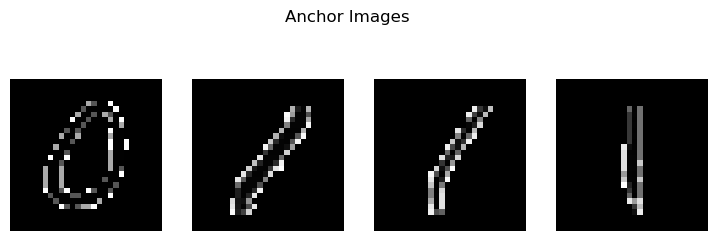

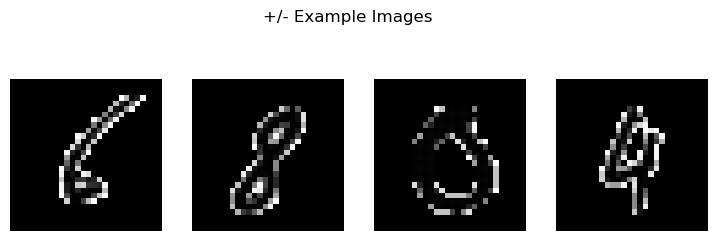

In [4]:
def show_images(images, title =''):
    num_images = len(images)
    fig,axes = plt.subplots(1, num_images,figsize=(9,3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img,cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()
    
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainloader):
    #converting tensors to numpy, numpy is easy to muniplate and display with matplotlib
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    #display some imgages from batch
    show_images(anchor_images[:4], title = 'Anchor Images')
    show_images(contrastive_images[:4], title = '+/- Example Images')
    #break after displaying from one batch for demostration 
    break

# lets build Neural Network
-  Define a neural network architecture with two convolution layers and two fully connected layers
- Input to the network is an MNIST image and Output is a 64 dimensional representation. 


In [5]:
from Network import Network, ContrastiveLoss

In [6]:
net = Network()

device= "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device= "mps"

net = net.to(device)
device

'mps'

In [7]:
optimizer = torch.optim.AdamW(net.parameters(), lr = 3e-4)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)


In [8]:
import os
checkpoint_dir ='checkpoints/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [9]:
# def save_checkpoint(net, epoch, checkpoint_dir='checkpoints'):
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
#     torch.save(net.state_dict(), checkpoint_path)

In [10]:

def Train_model(epoch_count=1):
    net = Network()
    net = net.to(device)
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        print('epoch-',epoch)
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        #lrs.append(optimizer.param_group[0]['lr'])
        print('learning rate',lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainloader):
            print(f"anchor shape: {anchor.shape}")
            print(f"contrastive shape: {contrastive.shape}")
            print(f"distance shape: {distance.shape}")

            #debugging shape and device 
            print(f"anchor device: {anchor.device}")
            print(f"contrastive device: {contrastive.device}")
            print(f"distance device: {distance.device}")
            
            # Ensure data is in the correct shape
            assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"


            
            batches +=1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)

            #debugging the data location in device
            print(f"anchor_out device after move: {anchor_out.device}")
            print(f"contrastive_out device after move: {contrastive_out.device}")
            print(f"distance device after move: {distance.device}")
            
            # anchor_out = net(anchor.to(device, dtype = torch.float32))
            # contrastive_out = net(contrastive.to(device, dtype = torch.float32))
            # distance = distance.to(torch.float32).to(device)
            # #distance = distance.to(device, dtype = torch.float32)

            # anchor = anchor.to(device)
            # contrastive = contrastive.to(device)
            # distance = distance.to(torch.float32).to(device)

            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
        
        losses.append(epoch_loss.cpu().detach().numpy()/ batches)
        scheduler.step()
        print('epoch_loss', losses[-1])

        #save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)
        
    return{
        "net": net,
        "losses":losses
    }
        

# load from backup

In [11]:
# def load_model_from_checkpoint():
#     checkpoint = torch.load('checkpoints/model_epoch_99.pt')

#     net = Network()
#     net.load_state_dict(checkpoint)
#     net.eval()

#     return net

In [12]:

# def save_checkpoint(net, epoch, checkpoint_dir='checkpoints'):
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
#     torch.save(net.state_dict(), checkpoint_path)
    


In [13]:

def load_latest_checkpoint(checkpoint_dir='checkpoints'):
    # List all checkpoint files
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('model_epoch') and f.endswith('.pt')]
    
    # Extract epoch numbers
    epochs = [int(re.findall(r'\d+', f)[0]) for f in checkpoint_files]
    
    # Find the latest epoch
    latest_epoch = max(epochs)
    latest_checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{latest_epoch}.pt')
    
    # Load the latest checkpoint
    checkpoint = torch.load(latest_checkpoint_path)
    net = Network()
    net.load_state_dict(checkpoint)
    net.eval()
    
    return net

In [14]:
train = True
checkpoint_dir = 'checkpoints'

if train:
    training_result = Train_model()
    model = training_result["net"]
else:
    model = load_latest_checkpoint(checkpoint_dir)

epoch- 0
learning rate 0.0003


  0%|          | 0/2563 [00:00<?, ?it/s]

anchor shape: torch.Size([16, 1, 28, 28])
contrastive shape: torch.Size([16, 1, 28, 28])
distance shape: torch.Size([16])
anchor device: cpu
contrastive device: cpu
distance device: cpu
anchor_out device after move: mps:0
contrastive_out device after move: mps:0
distance device after move: mps:0
Network forward function called
After conv1: torch.Size([16, 32, 12, 12])
After conv2: torch.Size([16, 64, 4, 4])
After view: torch.Size([16, 1024])
After linear1: torch.Size([16, 64])
Network forward function called
After conv1: torch.Size([16, 32, 12, 12])
After conv2: torch.Size([16, 64, 4, 4])
After view: torch.Size([16, 1024])
After linear1: torch.Size([16, 64])
anchor shape: torch.Size([16, 1, 28, 28])
contrastive shape: torch.Size([16, 1, 28, 28])
distance shape: torch.Size([16])
anchor device: cpu
contrastive device: cpu
distance device: cpu
anchor_out device after move: mps:0
contrastive_out device after move: mps:0
distance device after move: mps:0
Network forward function called
Afte

In [ ]:
from IPython.display import Image

if train:
    plt.plot(training_result[losses])
    plt.show()
else:
    